# MNLI task 를 해결하는 모델 만들기

- MNLI(Multi-Genre Natural Language Inference)는 자연어 추론(Natural Language Inference) 작업의 한 유형입니다. 
- 이 작업은 두 개의 문장(전제와 가설)이 주어졌을 때, 그들 사이의 논리적 관계를 판단하는 것입니다.
- MNLI에서는 세 가지 관계 중 하나로 분류합니다.
    - 함의(entailment): 전제가 가설을 논리적으로 함의하는 경우
    - 모순(contradiction): 전제가 가설과 모순되는 경우
    - 중립(neutral): 전제와 가설 사이에 명확한 논리적 관계가 없는 경우

## 데이터셋
- [nyu-mll/glue](https://huggingface.co/datasets/nyu-mll/glue) 에서 MNLI task 에 해당하는 데이터셋을 사용합니다.
- "nyu-mll/glue"는 New York University Machine Learning Lab에서 제공하는 GLUE 벤치마크 데이터셋입니다.
- GLUE 벤치마크의 여러 개의 task 중 "mnli"를 가져와서 사용합니다.
- 데이터셋은 아래와 같이 구성되어 있습니다.
    - train:
    - validation_matched:
    - validation_mismatched:
    - test_matched:
    - test_mismatched:
- 데이터셋의 각 데이터는 아래와 같이 구성되어 있습니다.
    - premise: 전제 문장
    - hypothesis: 가설 문장
    - label: 두 문장의 관계로, entailment (0), neutral (1), contradiction (2) 중 하나를 가집니다.

In [13]:
import pprint
from datasets import load_dataset

dataset = load_dataset("nyu-mll/glue", "mnli")
print(dataset)
pprint.pprint(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
{'hypothesis': 'Product and geography are what make cream skimming work. ',
 'idx': 0,
 'label': 1,
 'premise': 'Conceptually cream skimming has two basic dimensions - product '
            'and geography.'}


In [15]:
NUM_DS_LABELS = 3
id2label = {0: "ENTAILMENT", 1: "NEUTRAL", 2: "CONTRADICTION"}
label2id = {"ENTAILMENT": 0, "NEUTRAL": 1, "CONTRADICTION": 2}

In [ ]:
# dependencies
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)

import evaluate
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
# compute metrics 정의
accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## MNLI 용 파인 튜닝된 DistilBERT 모델 만들기

### DistilBERT 로딩

In [16]:
fine_tuning_d_bert = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_DS_LABELS,
    id2label=id2label,
    label2id=label2id,
)

# freezing
for param in fine_tuning_d_bert.distilbert.parameters():
    param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### DistilBERT 의 Tokenizer 로딩

In [17]:
d_bert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/Users/joyuiyeong/.pyenv/versions/3.11.9/envs/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 데이터셋 전처리

In [18]:
def preprocess_function_by_d_bert_tokenizer(data):
    return d_bert_tokenizer(
        data["premise"], data["hypothesis"], truncation=True, padding="max_length"
    )


d_bert_tokenized_ds = dataset.map(preprocess_function_by_d_bert_tokenizer, batched=True)

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

### 데이터셋 분할

In [19]:
d_bert_ds_split = d_bert_tokenized_ds["train"].train_test_split(test_size=0.2)
d_bert_train_ds = d_bert_ds_split["train"]
d_bert_val_ds = d_bert_ds_split["test"]

len(d_bert_train_ds), len(d_bert_val_ds)

(314161, 78541)

### TrainingArguments 설정

In [20]:
DISTILBERT_DIR_OUTPUT = "../data/fine_tuned_distilbert_for_mnli"
DISTILBERT_EPOCHS = 10
DISTILBERT_LEARNING_RATE = 1e-3
DISTILBERT_BATCH_SIZE = 64

In [21]:
d_bert_training_args = TrainingArguments(
    output_dir=DISTILBERT_DIR_OUTPUT,
    logging_dir=f"{DISTILBERT_DIR_OUTPUT}/logs",
    logging_strategy="epoch",
    num_train_epochs=DISTILBERT_EPOCHS,
    per_device_train_batch_size=DISTILBERT_BATCH_SIZE,
    per_device_eval_batch_size=DISTILBERT_BATCH_SIZE,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=DISTILBERT_LEARNING_RATE,
    load_best_model_at_end=True,
)
d_bert_training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_st

### Trainer 설정

In [23]:
d_bert_trainer = Trainer(
    model=fine_tuning_d_bert,
    args=d_bert_training_args,
    train_dataset=d_bert_train_ds,
    eval_dataset=d_bert_val_ds,
    compute_metrics=compute_metrics,
    tokenizer=d_bert_tokenizer,
)

In [24]:
d_bert_trainer.train()

  0%|          | 0/49090 [00:00<?, ?it/s]

{'loss': 1.0228, 'grad_norm': 0.8571290373802185, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9895905256271362, 'eval_accuracy': 0.508116779771075, 'eval_runtime': 829.2323, 'eval_samples_per_second': 94.715, 'eval_steps_per_second': 1.481, 'epoch': 1.0}
{'loss': 1.0003, 'grad_norm': 0.798147439956665, 'learning_rate': 0.0008, 'epoch': 2.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9792424440383911, 'eval_accuracy': 0.5200850511197973, 'eval_runtime': 831.0471, 'eval_samples_per_second': 94.508, 'eval_steps_per_second': 1.478, 'epoch': 2.0}
{'loss': 0.9926, 'grad_norm': 0.7800757884979248, 'learning_rate': 0.0007, 'epoch': 3.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9763416647911072, 'eval_accuracy': 0.515857959537057, 'eval_runtime': 829.7049, 'eval_samples_per_second': 94.661, 'eval_steps_per_second': 1.48, 'epoch': 3.0}
{'loss': 0.9855, 'grad_norm': 0.627221941947937, 'learning_rate': 0.0006, 'epoch': 4.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9675835371017456, 'eval_accuracy': 0.5256108274659095, 'eval_runtime': 830.535, 'eval_samples_per_second': 94.567, 'eval_steps_per_second': 1.479, 'epoch': 4.0}
{'loss': 0.9808, 'grad_norm': 0.6292604804039001, 'learning_rate': 0.0005, 'epoch': 5.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9650925993919373, 'eval_accuracy': 0.5289339325957143, 'eval_runtime': 828.978, 'eval_samples_per_second': 94.744, 'eval_steps_per_second': 1.481, 'epoch': 5.0}
{'loss': 0.9772, 'grad_norm': 0.686582088470459, 'learning_rate': 0.0004, 'epoch': 6.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9615627527236938, 'eval_accuracy': 0.5327153970537681, 'eval_runtime': 828.8943, 'eval_samples_per_second': 94.754, 'eval_steps_per_second': 1.481, 'epoch': 6.0}
{'loss': 0.9732, 'grad_norm': 0.8873637318611145, 'learning_rate': 0.0003, 'epoch': 7.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9536685347557068, 'eval_accuracy': 0.537961064921506, 'eval_runtime': 829.273, 'eval_samples_per_second': 94.711, 'eval_steps_per_second': 1.481, 'epoch': 7.0}
{'loss': 0.9697, 'grad_norm': 0.9041162729263306, 'learning_rate': 0.0002, 'epoch': 8.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9520647525787354, 'eval_accuracy': 0.5381647801785054, 'eval_runtime': 831.1181, 'eval_samples_per_second': 94.5, 'eval_steps_per_second': 1.478, 'epoch': 8.0}
{'loss': 0.9662, 'grad_norm': 0.6693928241729736, 'learning_rate': 0.0001, 'epoch': 9.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.9501137137413025, 'eval_accuracy': 0.539692644606002, 'eval_runtime': 828.8853, 'eval_samples_per_second': 94.755, 'eval_steps_per_second': 1.482, 'epoch': 9.0}
{'loss': 0.9634, 'grad_norm': 0.7644863724708557, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1228 [00:00<?, ?it/s]

{'eval_loss': 0.94675213098526, 'eval_accuracy': 0.5425573904075578, 'eval_runtime': 828.8038, 'eval_samples_per_second': 94.764, 'eval_steps_per_second': 1.482, 'epoch': 10.0}
{'train_runtime': 49873.4583, 'train_samples_per_second': 62.992, 'train_steps_per_second': 0.984, 'train_loss': 0.9831691273362702, 'epoch': 10.0}


TrainOutput(global_step=49090, training_loss=0.9831691273362702, metrics={'train_runtime': 49873.4583, 'train_samples_per_second': 62.992, 'train_steps_per_second': 0.984, 'total_flos': 4.1616832593060864e+17, 'train_loss': 0.9831691273362702, 'epoch': 10.0})

In [ ]:
d_bert_trainer.save_model()

In [ ]:
fine_tuned_d_bert_results = d_bert_trainer.evaluate(
    d_bert_tokenized_ds["validation_matched"]
)
fine_tuned_d_bert_results

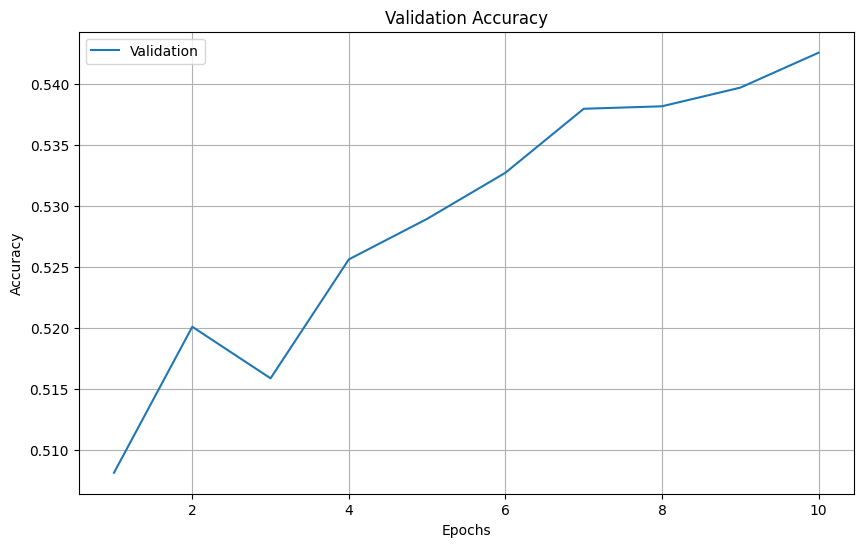

Final validation accuracy: 0.5397


In [25]:
d_bert_accuracies = [
    log["eval_accuracy"]
    for log in d_bert_trainer.state.log_history
    if "eval_accuracy" in log
]


epochs = range(1, DISTILBERT_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, d_bert_accuracies[:-1], label="Validation")
plt.axhline(y=d_bert_accuracies[-1], color="r", linestyle="--", label="Test")
plt.title("Fine-tuned DistilBERT Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Validation Accuracy: {d_bert_accuracies[-2]:.4f}")
print(f"Final Test Accuracy: {d_bert_accuracies[-1]:.4f}")

## MNLI 용 파인 튜닝된 GPT-2 모델 만들기

In [27]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# 토크나이저와 모델 로드
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
fine_tuinig_gpt2 = GPT2ForSequenceClassification.from_pretrained(
    "openai-community/gpt2",
    num_labels=NUM_DS_LABELS,
    id2label=id2label,
    label2id=label2id,
)

# GPT-2 토크나이저에는 기본적으로 패딩 토큰이 없으므로 추가
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
fine_tuinig_gpt2.config.pad_token_id = fine_tuinig_gpt2.config.eos_token_id

# GPT-2 모델의 모든 레이어들을 freeze
for param in fine_tuinig_gpt2.transformer.parameters():
    param.requires_grad = False


# 데이터셋에 전처리 적용
def preprocess_function(data):
    return gpt2_tokenizer(
        data["premise"], data["hypothesis"], truncation=True, padding="max_length"
    )


gpt2_tokenized_dataset = dataset.map(preprocess_function, batched=True)

# 데이터셋 분리
gpt2_ds_split = gpt2_tokenized_dataset["train"].train_test_split(test_size=0.2)
gpt2_train_dataset = gpt2_ds_split["train"]
gpt2_val_dataset = gpt2_ds_split["test"]

# TrainingArguments 설정
GPT_DIR_OUTPUT = "../data/fine_tuned_gpt2_for_mnli"
GPT_DIR_LOGGING = f"{GPT_DIR_OUTPUT}/logs"
GPT_EPOCHS = 10
GPT_LEARNING_RATE = 1e-3
GPT_BATCH_SIZE = 64

gpt_training_args = TrainingArguments(
    output_dir=GPT_DIR_OUTPUT,
    num_train_epochs=GPT_EPOCHS,
    per_device_train_batch_size=GPT_BATCH_SIZE,
    per_device_eval_batch_size=GPT_BATCH_SIZE,
    learning_rate=GPT_LEARNING_RATE,
    logging_dir=GPT_DIR_LOGGING,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Trainer 초기화
gpt2_trainer = Trainer(
    model=fine_tuinig_gpt2,
    args=gpt_training_args,
    train_dataset=gpt2_train_dataset,
    eval_dataset=gpt2_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=gpt2_tokenizer,
)

/Users/joyuiyeong/.pyenv/versions/3.11.9/envs/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [ ]:
gpt2_trainer.train()

In [ ]:
gpt2_trainer.save_model()

In [ ]:
fine_tuned_gpt2_result = gpt2_trainer.evaluate(
    d_bert_tokenized_ds["validation_matched"]
)
fine_tuned_gpt2_result

In [ ]:
gpt2_accuracies = [
    log["eval_accuracy"]
    for log in gpt2_trainer.state.log_history
    if "eval_accuracy" in log
]


epochs = range(1, DISTILBERT_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, gpt2_accuracies[:-1], label="Validation")
plt.axhline(y=gpt2_accuracies[-1], color="r", linestyle="--", label="Test")
plt.title("Fine-tuned GPT-2 Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Validation Accuracy: {gpt2_accuracies[-2]:.4f}")
print(f"Final Test Accuracy: {gpt2_accuracies[-1]:.4f}")